In [1]:
import pennylane as qml
from itertools import combinations
import networkx as nx
import numpy as np
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt

### Global variables

In [2]:
j=2
eps=1.0
g=1.0
V=1.0

v = 3#12 #initial state
n_qubits = 4*j

In [3]:
# Parameters for time evolution

t_max = 7.0                 # Maximum evolution time
time_steps = 30            # Number of time intervals
n_trotter_steps = 10        # Number of Trotter steps

# Define the time intervals
times = np.linspace(0, t_max, time_steps)

## Encoding Method

In [4]:
# Encode indices with the specified rule
def encode_indices(p, m, j):
    if p not in {1, -1}:
        raise ValueError("p must be either 1 or -1.")
    if m == 0 or not (-j <= m <= j):
        raise ValueError(f"m must be in the range +/-1, +/-2, ..., +/-j, but got m={m} and j={j}.")

    if m > 0:
        k = j - m
    else:
        k = j - m - 1 # shift by one because m can't be 0

    if p == -1:
        k += 2 * j

    return k

# Decode a single index back into multi-indices (p, m, j)
def decode_index(k, j):
    if k < 0 or k >= 4 * j:
        raise ValueError(f"k={k} is out of valid range for j={j}.")

    # Determine p based on the range of k
    p = 1 if k < 2 * j else -1

    # Adjust k for p = -1
    k_adjusted = k if p == 1 else k - 2 * j

    # Determine m
    m = j - k_adjusted if k_adjusted < j else j - (k_adjusted + 1) # inverse of the encoding line in encode_indices

    return p, m

## Test Encoding

In [5]:

for p in [1, -1]:
    for m in range(j, -j-1, -1):
        if m == 0: continue

        k = encode_indices(p, m, j)
        p_, m_ = decode_index(k, j)

        print("Original indices: p={}, m={}".format(p, m, j))
        print("Decoded indices:  p={}, m={}".format(p_, m_))
        print("Encoded index:    k={}".format(k))
        print()

Original indices: p=1, m=2
Decoded indices:  p=1, m=2
Encoded index:    k=0

Original indices: p=1, m=1
Decoded indices:  p=1, m=1
Encoded index:    k=1

Original indices: p=1, m=-1
Decoded indices:  p=1, m=-1
Encoded index:    k=2

Original indices: p=1, m=-2
Decoded indices:  p=1, m=-2
Encoded index:    k=3

Original indices: p=-1, m=2
Decoded indices:  p=-1, m=2
Encoded index:    k=4

Original indices: p=-1, m=1
Decoded indices:  p=-1, m=1
Encoded index:    k=5

Original indices: p=-1, m=-1
Decoded indices:  p=-1, m=-1
Encoded index:    k=6

Original indices: p=-1, m=-2
Decoded indices:  p=-1, m=-2
Encoded index:    k=7



## Hamiltonian

In [6]:
# Annihilation operator
def C(p, m, j):
    return qml.FermiA(encode_indices(p, m, j))

# Creation operator
def C_dag(p, m, j):
    return qml.FermiC(encode_indices(p, m, j))

# Agassi Hamiltonian
def agassi_hamiltonian(j, eps, g, V):
    
    # J0 term
    J0 = 0
    for m in range(j, -j-1, -1):
        if m == 0: continue
        J0 += C_dag(1, m, j) * C(1, m, j) - C_dag(-1, m, j) * C(-1, m, j)
    J0 *= 0.5

    # J+ and J- term
    J_plus = 0
    J_minus = 0
    for m in range(j, -j-1, -1):
        if m == 0: continue
        J_plus  += C_dag(1, m, j) * C(-1, m, j)
        J_minus += C_dag(-1, m, j) * C(1, m, j)

    # A_i terms
    
    def A_dag(p, j):
        res = 0
        # unlike the previous loops here we go from m=0 to m=j-1 (m=1 to m=j in the paper)
        for m in range(0, j+1):
            if m == 0: continue
            res += C_dag(p, m, j) * C_dag(p, -m, j)
        return res
    
    def A(p, j):
        res = 0
        # unlike the previous loops here we go from m=0 to m=j-1 (m=1 to m=j in the paper)
        for m in range(0, j+1):
            if m == 0: continue
            res += C(p, -m, j) * C(p, m, j)
        return res

    A_terms = 0
    for p in [-1, 1]:
        for p_ in [-1, 1]:
            A_terms += A_dag(p, j) * A(p_, j)
    
    
    # Hamiltonian
    H = eps * J0 - g * A_terms - V/2 * (J_plus * J_plus + J_minus * J_minus)
    
    return H

H_sec = agassi_hamiltonian(j, eps, g, V)
print("Second quantization Hamiltonian:")
print(H_sec)
print()

H_ps = qml.jordan_wigner(H_sec, ps=True, wire_map={0: 0, 1: 1, 2: 2, 3: 3})
# H = H.simplify()
print("Jordan-Wigner Hamiltonian:")
print(H_ps)
print()


Second quantization Hamiltonian:
-0.5 * a⁺(0) a(4) a⁺(0) a(4)
+ -0.0 * a⁺(0) a(4)
+ -0.5 * a⁺(0) a(4) a⁺(1) a(5)
+ -0.5 * a⁺(0) a(4) a⁺(2) a(6)
+ -0.5 * a⁺(0) a(4) a⁺(3) a(7)
+ 0.0 * I
+ -0.0 * a⁺(1) a(5)
+ -0.0 * a⁺(2) a(6)
+ -0.0 * a⁺(3) a(7)
+ -0.5 * a⁺(1) a(5) a⁺(0) a(4)
+ -0.5 * a⁺(1) a(5) a⁺(1) a(5)
+ -0.5 * a⁺(1) a(5) a⁺(2) a(6)
+ -0.5 * a⁺(1) a(5) a⁺(3) a(7)
+ -0.5 * a⁺(2) a(6) a⁺(0) a(4)
+ -0.5 * a⁺(2) a(6) a⁺(1) a(5)
+ -0.5 * a⁺(2) a(6) a⁺(2) a(6)
+ -0.5 * a⁺(2) a(6) a⁺(3) a(7)
+ -0.5 * a⁺(3) a(7) a⁺(0) a(4)
+ -0.5 * a⁺(3) a(7) a⁺(1) a(5)
+ -0.5 * a⁺(3) a(7) a⁺(2) a(6)
+ -0.5 * a⁺(3) a(7) a⁺(3) a(7)
+ -0.5 * a⁺(4) a(0) a⁺(4) a(0)
+ -0.0 * a⁺(4) a(0)
+ -0.5 * a⁺(4) a(0) a⁺(5) a(1)
+ -0.5 * a⁺(4) a(0) a⁺(6) a(2)
+ -0.5 * a⁺(4) a(0) a⁺(7) a(3)
+ -0.0 * a⁺(5) a(1)
+ -0.0 * a⁺(6) a(2)
+ -0.0 * a⁺(7) a(3)
+ -0.5 * a⁺(5) a(1) a⁺(4) a(0)
+ -0.5 * a⁺(5) a(1) a⁺(5) a(1)
+ -0.5 * a⁺(5) a(1) a⁺(6) a(2)
+ -0.5 * a⁺(5) a(1) a⁺(7) a(3)
+ -0.5 * a⁺(6) a(2) a⁺(4) a(0)
+ -0.5 * a⁺(6) a(2) a⁺(5

Split Hamiltonian for trotterization


## Determine hamiltonian components for trotterization

#### Add Implicit Terms to Hamiltonian

In [7]:
from copy import deepcopy

def add_implicit_terms(H1_raw, n_qubits):
    H_new = deepcopy(H1_raw)
    for i in range(0, n_qubits):
        w = qml.pauli.PauliWord({i:"Z"})
        if w not in H1_raw:
            H_new[w] = 0.0
    return H_new

#### Plot Cliquets

In [8]:
def draw_cliquet_decomposition(G_base, cliques):
     
    #plot graph with cliques

    import matplotlib.pyplot as plt
    import numpy as np

    # Define a list of colors for different cliques
    # colors = plt.cm.get_cmap("tab10", len(cliques))  # Get distinct colors
    # colors = plt.cm.get_cmap("Set1", len(cliques))  # "Set1" provides bright, distinct colors

    def generate_vibrant_colors(n_colors):
        """
        Generate a list of 'n_colors' distinct, vibrant colors while avoiding gray-like colors.
        """
        cmap = plt.cm.get_cmap("hsv", n_colors * 2)  # Use HSV colormap for high-saturation colors
        colors = [cmap(i) for i in range(n_colors * 2)]  # Get extra colors to filter

        # Keep only highly saturated colors (skip grays)
        vibrant_colors = [color for color in colors if np.mean(color[:3]) < 0.75]  # Avoid desaturated tones

        return vibrant_colors[:n_colors]  # Return only the needed number of colors

    # Example: Generate 15 vibrant colors with no grays
    num_cliques = len(cliques)  # Arbitrary dimension
    colors = generate_vibrant_colors(num_cliques)


    # Plot the original graph
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G_base)  # Position nodes

    # Draw the original graph in gray (background)
    # nx.draw(G_base, pos, edgelist=[], with_labels=True, node_color="red", edge_color="red", node_size=100, font_size=10)
    nx.draw(G_base, pos, with_labels=True, node_color="lightgray", edge_color="gray", node_size=50, font_size=10, alpha=0.2)


    # Draw each clique with a different color
    for i, clique in enumerate(cliques):
        nx.draw_networkx_nodes(G_base, pos, nodelist=clique, node_color=[colors[i]], node_size=200, alpha=0.5)
        nx.draw_networkx_edges(G_base, pos, edgelist=[(u, v) for u in clique for v in clique if G_base.has_edge(u, v)], edge_color=[colors[i]], width=2, alpha=0.5)

    plt.title("Original Graph with Highlighted Cliques")
    plt.show()

#### Get Cliquets

In [9]:
def get_hamiltonian_graph(H):
    H_list = list(zip(H_ps.keys(), H.values()))
    G = nx.Graph()
    G.add_nodes_from(H_list)

    # Compute commutators and add edges if they commute
    for i in range(len(H_list)):
        for k in range(i + 1, len(H_list)):
            a = H_list[i][0]
            b = H_list[k][0]
            if len(a.commutator(b)) == 0:  # Check commutation
                G.add_edge(H_list[i], H_list[k])
    return G


def get_clique_partitioning(G, verbose=False):

    cliques = []
    iteration = 1
    while G.number_of_nodes() > 0:
        iter_node = nx.find_cliques(G)
        try:
            clique = next(iter_node)
        except StopIteration:
            break  # If no more cliques, exit loop

        if verbose:
            print(f"Iteration {iteration}: Removing clique {clique}")
        
        # Remove clique from graph
        cliques.append(clique)
        G.remove_nodes_from(clique)
        iteration += 1

    if verbose:
        print("Final graph (should be empty):", G.nodes())

    return cliques


def construct_hamiltonian_terms_from_cliques(cliques):
    H_terms = []
    for i in range(len(cliques)):
        H_term = qml.pauli.PauliSentence()
        for k in range(len(cliques[i])):
            H_term[cliques[i][k][0]] = cliques[i][k][1]
        H_terms.append(H_term)
    return H_terms

In [10]:
def get_best_clique_partitioning(G_base, num_iter=10, verbose=False):
    best_cliques = None
    best_err = np.inf
    seed = 65433455
    import random
    import numpy
    for i in range(num_iter):
        random.seed(seed + i*100)        # or any integer
        numpy.random.seed(seed + i*100)
        G = G_base.copy()
        cliques = get_clique_partitioning(G, verbose=verbose)

        H_terms = construct_hamiltonian_terms_from_cliques(cliques)
        
        H_terms_mat = []
        for H_term in H_terms:
            order = list(range(n_qubits))
            for i in range(0,n_qubits):
                order[i]=i
            H_terms_mat.append(qml.matrix(add_implicit_terms(H_term, n_qubits=n_qubits), wire_order=order))

            # print(H_terms_mat[-1].shape)

        err = 0#linalg.norm(x, ord=None, axis=None, keepdims=False)
        for i in range(len(H_terms_mat)):
            for j in range(len(H_terms_mat)):
                comm = H_terms_mat[i] @ H_terms_mat[j] - H_terms_mat[j] @ H_terms_mat[i]
                err += np.linalg.norm(comm, ord=2)

        print(err)

        # comm = ...
        if err < best_err:
            best_cliques = cliques
    
    return best_cliques

In [11]:
G = get_hamiltonian_graph(H_ps)
G_base = G.copy()
# cliques = get_clique_partitioning(G, verbose=True)
# H_terms = construct_hamiltonian_terms_from_cliques(cliques)

cliques = get_best_clique_partitioning(G, num_iter=10, verbose=False)
H_terms = construct_hamiltonian_terms_from_cliques(cliques)


110.16409189425532
110.16409189425532
110.16409189425532
110.16409189425532
110.16409189425532
110.16409189425532
110.16409189425532
110.16409189425532
110.16409189425532
110.16409189425532


/var/folders/_h/zshrjsxs42s1yscqytrdy2q00000gn/T/ipykernel_63201/930723683.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("hsv", n_colors * 2)  # Use HSV colormap for high-saturation colors


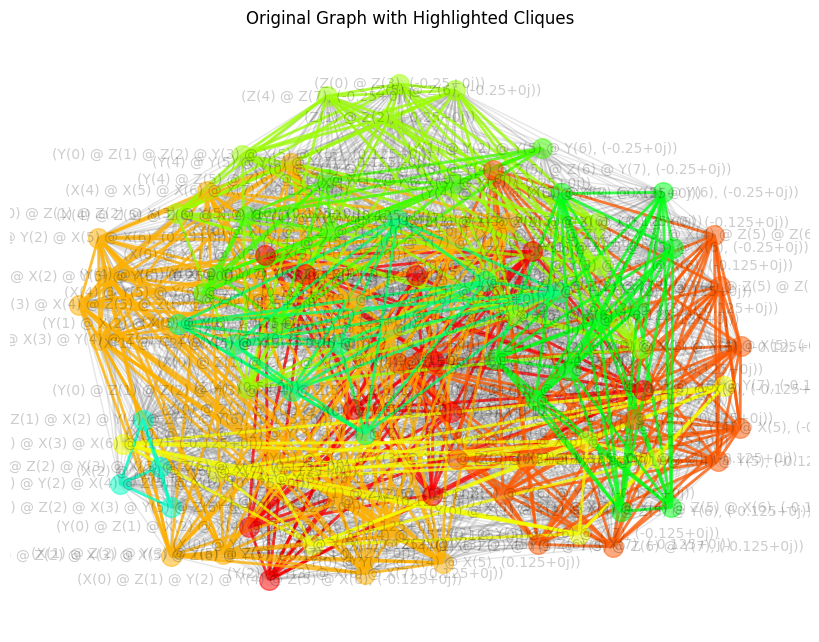

In [12]:
draw_cliquet_decomposition(G_base, cliques)

## Automatically Calculate Commutators

In [13]:
#calculate commutators of terms in H

def test_commutativity(H):
    
    split_sentences1 = {}

    for pauli_word, value in H.items():
        # If this number is not already in the dictionary, initialize a new PauliSentence
        if pauli_word not in split_sentences1:
            split_sentences1[pauli_word] = qml.pauli.PauliSentence()

    # Iterate over all pairs of PauliSentences from split_sentences2 and test commutativity
    for (key1, ps1), (key2, ps2) in combinations(split_sentences1.items(), 2):
        # Compute their commutator
        comm = qml.commutator(key1,key2, pauli=True)
        

        # Check if they commute
        if np.allclose(comm.operation().matrix(), 0):
            # print(f"{key1} and {key2} commute.")
            # print("COMMUTE")
            pass
        else:
            print("DO NOT COMMUTE")
            # print(f"{key1} and {key2} do NOT commute.")

In [14]:
for i in range(len(H_terms)):
    test_commutativity(H_terms[i])

In [15]:
#test commutation between different split of hamiltonian

import pennylane as qml

def test_commutativity_between_split(H_terms):
    """Check commutativity of all pairs in the given list of Pauli words."""
    num_terms = len(H_terms)
    commutation_results = {}

    for i in range(num_terms):
        for j in range(i + 1, num_terms):  # Check only unique pairs (i, j)
            ps1 = H_terms[i]
            ps2 = H_terms[j]
            
            # Compute the commutator using PennyLane
            comm = ps1.commutator(ps2)

            # Check if the commutator is empty (i.e., they commute)
            is_commuting = len(comm) == 0
            commutation_results[(i, j)] = is_commuting

            print(f"Commutator of term {i} and term {j}: {'Commute' if is_commuting else 'Do not commute'}")
            print(comm)

    return commutation_results

commutation_results = test_commutativity_between_split(H_terms)

Commutator of term 0 and term 1: Do not commute
-0.03125j * X(1) @ X(2) @ Z(4) @ X(5) @ Y(6)
+ 0.03125j * Z(0) @ Y(1) @ X(2) @ Y(5) @ Y(6)
+ -0.125j * Y(0) @ Z(1) @ X(2) @ X(4) @ Z(5) @ X(6)
+ 0.0625j * Y(2) @ X(3) @ Z(4) @ X(6) @ X(7)
+ -0.0625j * Z(0) @ Y(2) @ Y(3) @ X(6) @ Y(7)
+ -0.03125j * Y(1) @ X(2) @ Z(4) @ Y(5) @ Y(6)
+ 0.03125j * Z(0) @ X(1) @ X(2) @ X(5) @ Y(6)
+ 0.0625j * Y(2) @ Y(3) @ Z(4) @ X(6) @ Y(7)
+ -0.0625j * Z(0) @ Y(2) @ X(3) @ X(6) @ X(7)
+ -0.03125j * Z(0) @ X(1) @ Y(2) @ X(5) @ X(6)
+ 0.03125j * Y(1) @ Y(2) @ Z(4) @ Y(5) @ X(6)
+ 0.125j * X(0) @ Z(1) @ Y(2) @ Y(4) @ Z(5) @ Y(6)
+ 0.0625j * Z(0) @ X(2) @ X(3) @ Y(6) @ X(7)
+ -0.0625j * X(2) @ Y(3) @ Z(4) @ Y(6) @ Y(7)
+ -0.03125j * Z(0) @ Y(1) @ Y(2) @ Y(5) @ X(6)
+ 0.03125j * X(1) @ Y(2) @ Z(4) @ X(5) @ X(6)
+ 0.0625j * Z(0) @ X(2) @ Y(3) @ Y(6) @ Y(7)
+ -0.0625j * X(2) @ X(3) @ Z(4) @ Y(6) @ X(7)
+ 0.125j * Y(0) @ Y(1) @ Y(4) @ X(5)
+ -0.125j * X(0) @ X(1) @ X(4) @ Y(5)
+ 0.125j * Y(1) @ Z(2) @ Y(3) @ X(5) @ Z

In [16]:

# from itertools import combinations
# from pennylane.pauli import PauliSentence

# # Iterate over all pairs of PauliSentences from split_result and test commutativity
# for (num_ops1, ps1), (num_ops2, ps2) in combinations(split_result.items(), 2):
#     # Compute their commutator
#     comm = ps1.commutator(ps2)

#     # Check if they commute
#     if len(comm) == 0:
#         print(f"Pauli sentences with {num_ops1} and {num_ops2} operators commute.")
#     else:
#         print(f"Pauli sentences with {num_ops1} and {num_ops2} operators do NOT commute.")

## Time Evolution functions

### create initial state

In [17]:

# Initial state

dim = 2**n_qubits
initial_state = np.zeros(dim, dtype=complex)
initial_state[v] = 1

print(initial_state.shape)
print(n_qubits)

(256,)
8


### get matrix form of hamiltonian terms

In [18]:
#get matrix form of all the hamiltonians

order = list(range(n_qubits))

for i in range(0,n_qubits):
    order[i]=i

H = qml.matrix(H_ps, wire_order=order)

# H = get_matrix_from_ps(H_ps)

H_terms_implicit = []
for term in H_terms:
    H_terms_implicit.append(add_implicit_terms(term, n_qubits))

H_terms_mat = []
for term in H_terms_implicit:
    # H_terms_mat.append(term.operation().matrix())
    H_terms_mat.append(qml.matrix(term, wire_order=order))





### define evolution and correlation function

In [19]:

# time evolution like in the paper
def paper_evo(t, n):
    U = np.identity(H.shape[0])
    for _ in range(0, n):
        for term in H_terms_mat:
            U = U @ expm(-1j * term * (t/n))
    
    evolved_state = U @ initial_state
    return evolved_state


# # time evolution second order
# def paper_evo(t, n):
#     print("### EVOLVE ###")
#     print("Len: ", len(H_terms_mat))
#     U = np.identity(H.shape[0])
#     for _ in range(0, n):
#         print("+++++++++++++")

#         for i in range(len(H_terms_mat)-1):
#             term = H_terms_mat[i]
#             print(i)
#             U = U @ expm(-0.5j * term * (t/n))

#         U = U @ expm(-1j * H_terms_mat[-1] * (t/n))

#         for i in range(len((H_terms_mat))-2, -1, -1):
#             term = H_terms_mat[i]
#             print(i)
#             U = U @ expm(-0.5j * term * (t/n))
    
#     evolved_state = U @ initial_state

#     print("### END EVOLVE ###")
#     return evolved_state


# exact time evolution
def exact_evo(t):
    U = np.identity(H.shape[0])
    U = U @ expm(-1j * H * (t)) 
    evolved_state = U @ initial_state
    return evolved_state


In [20]:
#compute correlation function
def correlation_function (i, j, evo):
    Zi_raw = qml.pauli.PauliWord({i:"Z"})
    Zj_raw = qml.pauli.PauliWord({j:"Z"})
    psi = qml.pauli.PauliSentence()
    psi[Zi_raw]= 1.0
    psj = qml.pauli.PauliSentence()
    psj[Zj_raw]= 1.0

    Zi=add_implicit_terms(psi, n_qubits).operation().matrix()
    Zj=add_implicit_terms(psj, n_qubits).operation().matrix()

    evo=paper_evo(t, n_trotter_steps)
    
    sigma_ij_trotter=np.vdot(evo,Zi @ Zj @ evo)-np.vdot(evo ,Zi @ evo)*np.vdot(evo,Zj @ evo)

    return sigma_ij_trotter

## Compute evolution 

### Paper Evolution

In [21]:
overlaps = []
correlations_trotter = []

# Compute the overlap with initial state
for t in times:
    result = paper_evo(t, n_trotter_steps)

    overlap = np.vdot(initial_state, result)
    overlap = np.abs(overlap)**2
    overlaps.append(overlap)

    # Compute the correlation function for trotterized evolution
    correlation_trotter = correlation_function(0, 1, result)
    correlations_trotter.append(correlation_trotter)
    




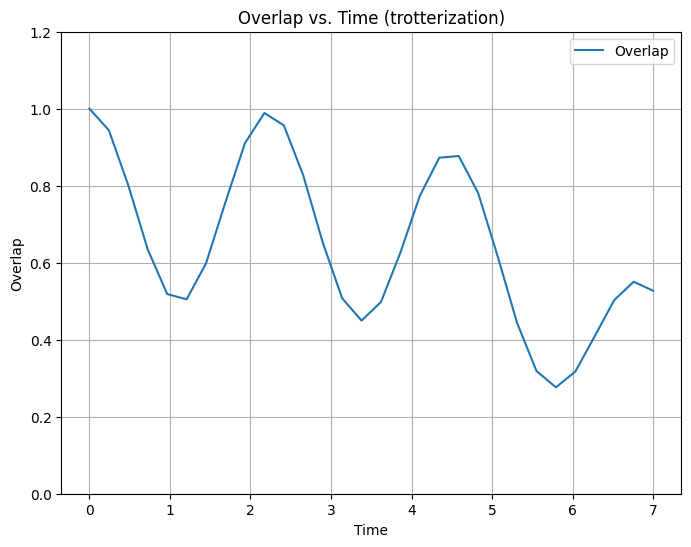

Final overlap: 0.5273672633003749


In [22]:


# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(times, overlaps, label="Overlap")
plt.xlabel("Time")
plt.ylabel("Overlap")
plt.ylim([0, 1.2])
plt.title("Overlap vs. Time (trotterization)")
plt.grid()
plt.legend()
plt.show()

print("Final overlap:", overlaps[-1])



### Exact Evolution

In [23]:

overlaps = []
correlations_exact = []

# Compute the overlap with initial state
for t in times:
    result = exact_evo(t)  
    #result = result.numpy()  # Convert to NumPy array if required
    
    overlap = np.vdot(initial_state, result) 
    overlap = np.abs(overlap)**2
    overlaps.append(overlap)

    correlation_exact = correlation_function(0, 1, result)
    correlations_exact.append(correlation_exact)


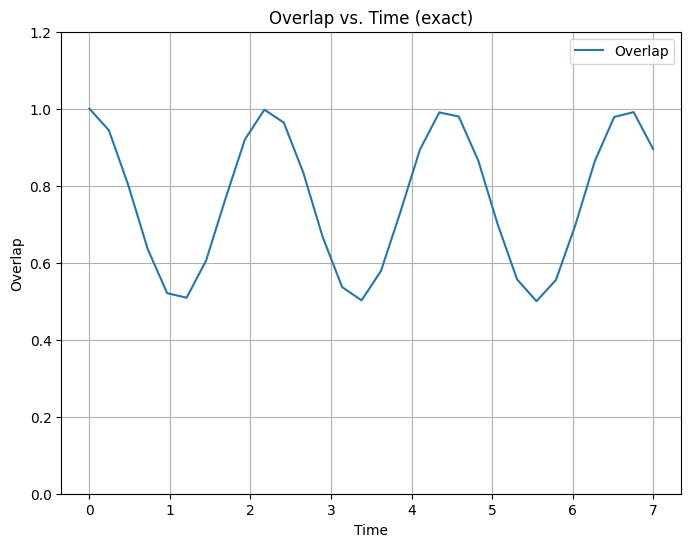

In [24]:

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(times, overlaps, label="Overlap")
plt.xlabel("Time")
plt.ylabel("Overlap")
plt.ylim([0, 1.2])
plt.title("Overlap vs. Time (exact)")
plt.grid()
plt.legend()
plt.show()



### Error

In [25]:
probabilities = []

# compute overlap between exact and paper evolution
for t in times:
    evolved_state_exact = exact_evo(t)
    evolved_state_trotter = paper_evo(t, n_trotter_steps)  # Execute the circuit
    # evolved_state_trotter = paper_evo_higher_order2(t, n_trotter_steps)  # Execute the circuit
    # evolved_state_trotter = evolved_state_trotter.numpy()  # uncomment when using pennylane_evo
    
    overlap = np.vdot(evolved_state_exact, evolved_state_trotter)
    probability = np.abs(overlap)**2
    probabilities.append(probability)

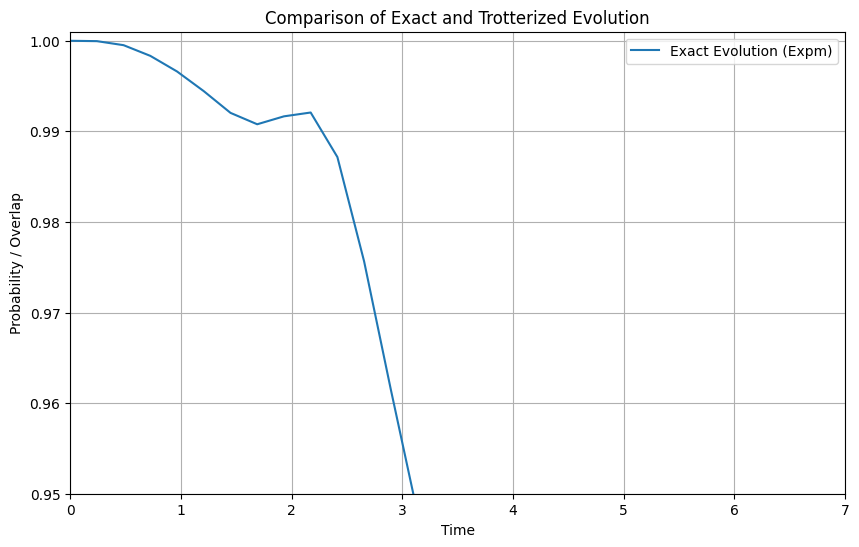

In [26]:
# Plot both results
plt.figure(figsize=(10, 6))
plt.plot(times, probabilities, label="Exact Evolution (Expm)", markersize=3)
plt.xlabel("Time")
plt.ylabel("Probability / Overlap")
plt.xlim([0, t_max])
plt.ylim([0.95, 1.001])
plt.title("Comparison of Exact and Trotterized Evolution")
plt.grid()
plt.legend()
plt.show()

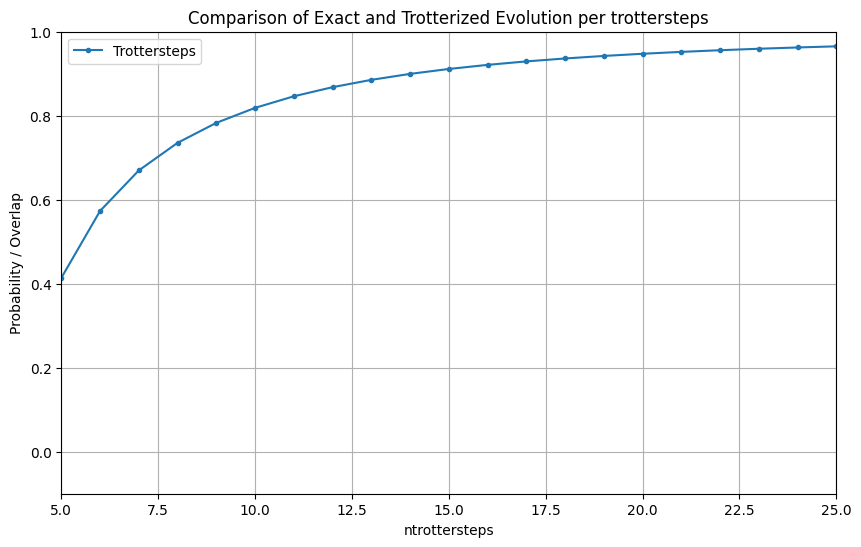

In [27]:
#comparison per number of trotter steps at given time

probabilities1 = []

min_trotter_step = 5
max_trotter_step = 25
trotter_steps = np.arange(min_trotter_step, max_trotter_step + 1)

# compute overlap between exact and paper evolution
for n in trotter_steps:
    evolved_state_exact = exact_evo(5)
    evolved_state_trotter = paper_evo(5, n)  # Execute the circuit
    # evolved_state_trotter = paper_evo_higher_order(5, n)  # Execute the circuit
    # evolved_state_trotter = evolved_state_trotter.numpy()  # uncomment when using pennylane_evo
    
    overlap = np.vdot(evolved_state_exact, evolved_state_trotter)
    probability = np.abs(overlap)**2
    probabilities1.append(probability)

# Plot both results
plt.figure(figsize=(10, 6))
plt.plot(trotter_steps, probabilities1, label="Trottersteps", marker="o", markersize=3)
plt.xlabel("ntrottersteps")
plt.ylabel("Probability / Overlap")
plt.xlim([min_trotter_step, max_trotter_step])
plt.ylim([-0.1, 1.001])
plt.title("Comparison of Exact and Trotterized Evolution per trottersteps")
plt.grid()
plt.legend()
plt.show()


/opt/miniconda3/envs/qubasta2/lib/python3.11/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/miniconda3/envs/qubasta2/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/miniconda3/envs/qubasta2/lib/python3.11/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


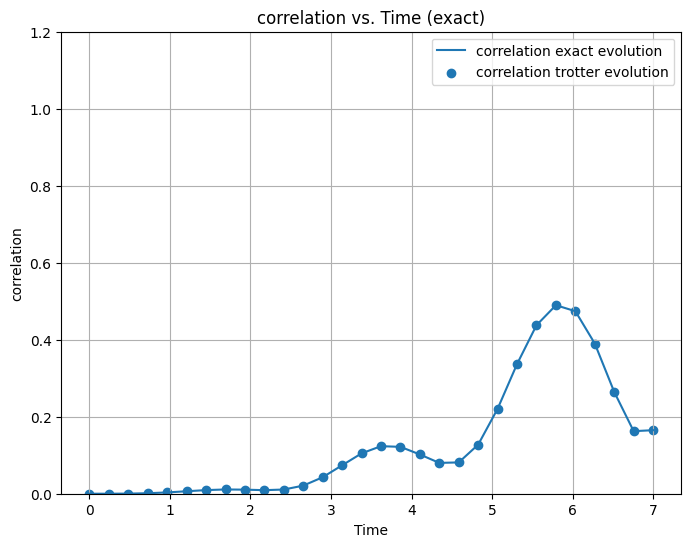

In [28]:
# Plot correlations

plt.figure(figsize=(8, 6))
plt.plot(times, correlations_exact, label="correlation exact evolution")
plt.scatter(times, correlations_trotter, label="correlation trotter evolution")
plt.xlabel("Time")
plt.ylabel("correlation")
plt.ylim([0, 1.2])
plt.title("correlation vs. Time (exact)")
plt.grid()
plt.legend()
plt.show()



## Extra

In [29]:


# dev = qml.device("default.qubit", wires=int(np.log2(H.shape[0])))
# @qml.qnode(dev)

# def pennylane_evo(t, n, v):
#     b=int(np.log2(H.shape[0]))
#     for i in range (0, b):
#         if v >= (2**(b-i-1)):
#             qml.PauliX(wires=(i))
#             v=v-2**(b-i-1)
#         # print(v)
#     qml.ApproxTimeEvolution(H_ps.hamiltonian(), t, n)
#     return qml.state()


### Check which initial states evolve

In [30]:
#checks for every inital state which one evolves

dim = 2**n_qubits
def get_initial_state(v):
    initial_state = np.zeros(dim, dtype=complex)
    initial_state[v] = 1
    return initial_state

print(initial_state.shape)

def exact_evo_all(t, v, H):
    initial_state=get_initial_state(v)
    U = np.identity(H.shape[0])
    U = U @ expm(-1j * H * (t)) 
    evolved_state = U @ initial_state
    overlap=np.abs(np.vdot(evolved_state, initial_state))**2
    return overlap

for v in range(0,2**n_qubits):
    print(exact_evo_all(5, v, H))

(256,)
1.0
0.9999999999999984
0.9999999999999984
0.7487578344668506
0.9999999999999984
0.7487578344668506
0.865344417052025
0.528274429680934
0.9999999999999984
0.8653444170520252
0.7487578344668506
0.5282744296809343
0.7487578344668506
0.528274429680934
0.5282744296809342
0.05356823611329643
0.9999999999999984
1.0
1.0
0.9999999999999984
1.0
0.9999999999999984
0.19615090129588617
0.22700129259554908
1.0
0.010976198297600513
0.10277741485303477
0.543579365125154
0.10277741485303465
0.5435793651251544
0.1731013384986799
0.5282744296809347
0.9999999999999984
1.0
1.0
0.9999999999999984
1.0
0.1027774148530349
0.010976198297600414
0.543579365125154
1.0
0.19615090129588514
0.9999999999999984
0.22700129259554908
0.10277741485303458
0.1731013384986799
0.5435793651251544
0.5282744296809356
0.7487578344668506
0.9999999999999984
0.9999999999999984
1.0
0.5481707532570069
1.0
0.08046423546177421
1.0000000000000018
0.5481707532570069
0.08046423546177436
1.0
1.0000000000000018
0.8584029218894925
0.102